In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import seaborn as sns
import scipy.stats as st
from scipy.special import gamma


In [40]:
ticker = 'bbas3' # Ticker of the stock to be analyzied

stock_string = (ticker+'.SA').upper() #Adjust the ticker to be in accordance with Yahoo Finance

stock = yf.Ticker(stock_string) # Create a ticker object of the Yahoo Finance library

In [41]:
start_date = datetime.datetime(2012,1,1) #Start date of the period under analysis 

end_date = datetime.date.today() # End date of the period under analysis

price = stock.history(start = start_date, end = end_date,interval='1d') # Data frame with the prices of the stock during the period

time = price.index #Series containing the time period under analysis

max_price = price['High'] # Series of Maximum price of the day 

min_price = price['Low'] # Series of Minimum price of the day





In [42]:
price.tail(8) # Checking out the data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-04-12,35.209999,35.490002,34.860001,35.000000,12418700.0,0.0,0
2022-04-13,35.410000,35.450001,34.900002,35.169998,12807900.0,0.0,0
2022-04-14,35.090000,35.540001,35.070000,35.200001,10692100.0,0.0,0
2022-04-18,35.189999,36.500000,35.119999,36.500000,22572600.0,0.0,0
2022-04-19,36.380001,36.680000,35.049999,35.209999,17886500.0,0.0,0
2022-04-20,35.240002,35.270000,34.810001,35.160000,11296200.0,0.0,0
2022-04-22,34.730000,34.770000,34.150002,34.430000,10923400.0,0.0,0
2022-04-25,34.250000,34.950001,33.970001,34.700001,11322400.0,0.0,0


In [43]:
delta = 6*2+1 # Number of days after and before a maximum or a minumum to consider wether it is a top or a bottom

In [44]:
filter_tops = max_price.rolling(window = delta,center = True).max() # At a day "d", an interval from "d-delta" until "d+delta" for the maximum prices is evaluated and the maximum value is stored
filter_bottoms =  min_price.rolling(window = delta,center = True).min() # At a day "d", an interval from "d-delta" until "d+delta" for the minimum prices is evaluated and the minimum value is stored

In [45]:
tops = max_price[max_price == filter_tops] # If the maximum price of day 'd' coincides with the maximum of the maximums from "d-delta" to "d+delta", it is a top
bottoms = min_price[min_price == filter_bottoms]  # If the maximum price of day 'd' coincides with the maximum of the maximums from "d-delta" to "d+delta", it is a bottom 

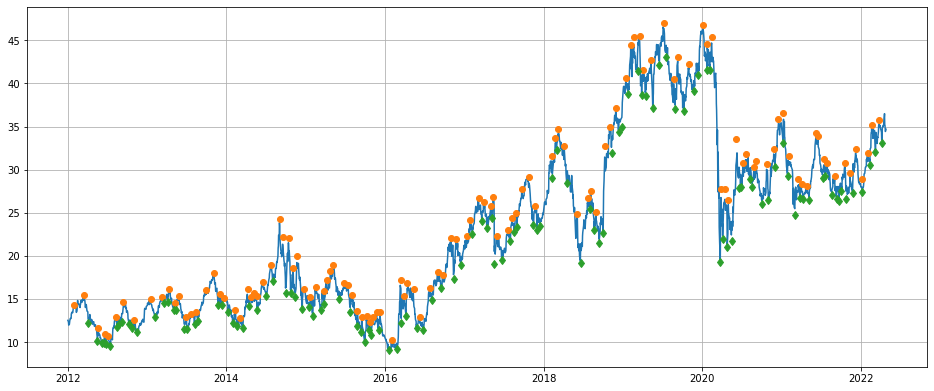

In [46]:
# Plotting the closing prince of the day and the identified tops and bottoms
# Some points were considered consecutive bottoms or tops, which will be correct later
bild = plt.figure(figsize=(5,5))
eixos= bild.add_axes([0,0,2.5,1])
eixos.plot(price['Close'])
eixos.plot(tops,'o')
eixos.plot(bottoms,'d')
plt.grid()

In [47]:
# Eliminating consecutive tops and bottoms
# The evaluation starts at end date and goes until start date. If two or more consecutive tops or bottoms are identified
# the highest top and the lowest bottom will be considered as the definitive top and bottom


tm = pd.concat([tops,bottoms]).sort_index() # Create a series with the tops and bottoms and sort it from start date to end date

tmm = pd.concat([tops,-bottoms]).sort_index() # Auxiliar siries with the bottoms multplied by -1

vector = np.arange(0,tmm.index.size)

for i in vector[-1:1:-1]: 
    

    if tmm.iloc[i]*tmm.iloc[i-1]>0:
        
        tm.iloc[i] = np.nan
        


tm.dropna(axis=0,inplace = True)

tops_bottoms = tm #Creat the series with tops and bottoms

tm = tm.pct_change()*100 # Calculate the rises and falls in porcentage

tm.dropna(axis=0,inplace = True) # Drop the firts NaN value

<AxesSubplot:ylabel='Count'>

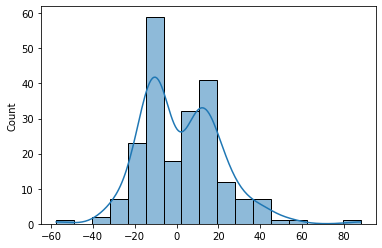

In [48]:
sns.histplot(tm,kde=True) # Distribuição dos retornos entre topos e fundos

In [53]:
str_a = 'The average fall is:{fmean:.2f} %'
str_a.format(fmean=tm[tm<0].mean())

'The average fall is:-13.25 %'

In [54]:
str_a = 'The average rise is:{fmean:.2f} %'
str_a.format(fmean=tm[tm>0].mean())

'The average rise is:18.11 %'

<AxesSubplot:ylabel='Count'>

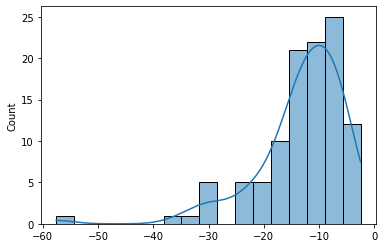

In [51]:
sns.histplot(tm[tm<0],kde=True) # Distribuição das quedas

In [55]:
## Considering a normal distribution

if (price['Close'][-1]/tops_bottoms[-1]-1) <0: # Check if today price is lower than the last top/bottom, if it is lower, we have a fall
    fall = tm[tm<0] # The fall series is created
    sigma = fall.std()
    mi = -fall.mean()
    queda = -(price['Close'][-1]/tops_bottoms[-1]-1)*100
    z = (queda-mi)/sigma
    prob = st.norm.cdf(z)
    msg = "The current fall is {qt:.2f} % and the probability to increase is {qf:.2f} %"
    msg_format = msg.format(qt=queda,qf=(1-prob)*100)


else: #If it is higher, we are at a rise
        
    up = tm[tm>0]
    sigma = up.std()
    mi = up.mean()
    alta = (price['Close'][-1]/tops_bottoms[-1]-1)*100
    z = (alta-mi)/sigma
    prob = st.norm.cdf(z)
    msg = "The current rise is {qt:.2f} % and the probability to increase is {qf:.2f} %"
    msg_format = msg.format(qt=alta,qf=(1-prob)*100,inplace=True)


print(msg_format)

The current rise is 4.71 % and the probability to increase is 84.93 %


In [58]:
# Considering a Weibull Distribution

if (price['Close'][-1]/tops_bottoms[-1]-1) <0:
    
    move_median = -fall.median()
    move_var = fall.std()**2
    move_mean = -fall.mean()
    move = -(price['Close'][-1]/tops_bottoms[-1]-1)*100
    msg_queda = "The current fall is {qt:.2f} % and the probability to increase is {qf:.2f} %"
    
    
else:
    move_median = up.median()
    move_var = up.std()**2
    move_mean = up.mean()
    move = (price['Close'][-1]/tops_bottoms[-1]-1)*100
    msg_alta = "The current rise is {qt:.2f} % and the probability to increase is {qf:.2f} %"

k_weibull_i = 5

erro = 1

cont = 0

rlx = 0.5

#Calculate the weibull distribution parameters numerically
while erro > 1e-3 and cont < 1e4:
    
    cont=cont+1
    lambda_weibull = move_mean/gamma(1+1/k_weibull_i)
    k_weibull = np.log(np.log(2))/np.log(move_median/lambda_weibull)
    erro = abs(k_weibull - k_weibull_i)
    print(erro)
    k_weibull_i = k_weibull_i*(1-rlx) + k_weibull*rlx
    
weib_pdf = lambda x: k_weibull/lambda_weibull * (x/lambda_weibull)**(k_weibull-1) * np.exp(-((x/lambda_weibull)**k_weibull))
weib_cdf = lambda x: 1 - np.exp(-(x/lambda_weibull)**k_weibull)
    
if (price['Close'][-1]/tops_bottoms[-1]-1) <0:
    
    print(msg_queda.format(qt=move,qf=(1-weib_cdf(move))*100)) 
    
    
else:
    print(msg_alta.format(qt=move,qf=(1-weib_cdf(move))*100))
    
   

3.3824186561252687
1.8413021965059806
0.9881177296087265
0.4876950293221509
0.20173772200429885
0.06669355634375362
0.018711992727545423
0.004890587108222544
0.001250570178059851
0.0003179111567259696
The current rise is 4.71 % and the probability to increase is 89.31 %


In [435]:
#Checking the weibull distribution

x_fall = np.arange(0,40,0.05)
pdf=weib_pdf(x_fall)

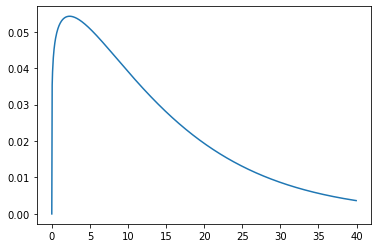

In [436]:
plt.plot(x_fall,pdf)